In [2]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
GOLD_DATA_PATH = "/data/group1/z40436a/ME/URL_Citation_Classification_Intermediate/data/all_data.csv"
csv_dataset = pd.read_csv(GOLD_DATA_PATH, index_col=0)
model_names = ["meta-llama/Llama-3.1-8B-Instruct"]
#"google/gemma-2-9b-it", "mistralai/Mistral-Nemo-Instruct-2407"]

In [4]:
def pred_type_and_func(LLM_responses: json) -> tuple[list, list]:
    type_preds = []
    func_preds = []

    for each_response in LLM_responses:
        # print(each_response[-1]['generated_text'])
        for each_turn in each_response[-1]['generated_text'][:-1]:
            if each_turn['role'] == 'assistant':
                try:
                    # print("TYPE:", completion['content'].split("TYPE: ")[1].split()[0])
                    type_preds.append(each_turn['content'].split("TYPE: ")[1].split()[0])
                except:
                    # print("format error")
                    type_preds.append("FormatError")
                try:
                    # print("FUNCTION:", completion['content'].split("FUNCTION: ")[1].split()[0])
                    func_preds.append(each_turn['content'].split("FUNCTION: ")[1].split()[0])
                except:
                    # print("format error")
                    func_preds.append("FormatError")

    return type_preds, func_preds

In [5]:
def evaluation_metrics(gold:list[str], pred:list[str], eval_mode:str) -> dict:
    if eval_mode == "type":
        label_set = ["Tool", "Code", "Dataset", "Knowledge", "DataSource", "Document", "Paper", "Media", "Website", "Mixed"]
    elif eval_mode == "func":
        label_set = ["Use", "Produce", "Compare", "Extend", "Introduce", "Other"]
    else:
        print("set apprepriate eval_mode")

    acc = accuracy_score(gold, pred)
    pre = precision_score(gold, pred, labels=label_set, average="macro", zero_division=0)
    rec = recall_score(gold, pred, average="macro", zero_division=0)
    if pre * rec == 0:
        f1 = 0
    else:
        f1 = 2 * pre * rec / (pre + rec)
    err_rate = pred.count('FormatError') / len(pred)

    return {"acc": acc, "pre":pre, "rec":rec, "f1":f1, "err": err_rate}

In [6]:
def round_print(input_dict:dict, round_num:int=3):
    rounded_data = {key: round(value, round_num) for key, value in input_dict.items()}
    print(rounded_data)

In [7]:
show_types = []
show_funcs = []

In [8]:
lst_for_graph = []

In [9]:
demo_types_seeds = []
demo_funcs_seeds = []
for model_name in model_names:
    print(model_name)
    for icl_method in ["random", "bm25", "encoder"]:
        print(f"icl_method = {icl_method}")
        for k in range(5, 5+1):
            print(f"{str(k)}-shot")
            metrics_types_seeds = []
            metrics_funcs_seeds = []
            demo_types_per_seed = []
            demo_funcs_per_seed = []
            # , 5374, 93279
            for seed in [111]:
                # print(seed)
                # create gold answer
                train_df, eval_df = train_test_split(csv_dataset, test_size = 0.1, random_state=int(seed))
                gold_types, gold_funcs = [], []
                for i, row in eval_df.iterrows():
                    gold_types.append(row['type'])
                    gold_funcs.append(row['function'].split("（")[0])

                # create pred answer
                pred_data_path = f"/data/group1/z40436a/ME/URL_Citation_Classification_Intermediate/result/output/{model_name}/{icl_method}/{str(seed)}_{str(k)}shot.json"
                with open(pred_data_path, 'r') as json_file:
                    LLM_responses = json.load(json_file)

                pred_types, pred_funcs = pred_type_and_func(LLM_responses)

                pred_types = [pred if pred in list(set(gold_types)) else "FormatError" for pred in pred_types]
                pred_funcs = [pred if pred in list(set(gold_funcs)) else "FormatError" for pred in pred_funcs]

                demo_types_per_seed += pred_types
                print(len(demo_types_per_seed))
                demo_funcs_per_seed += pred_funcs
            else:
                demo_types_seeds.append(demo_types_per_seed)
                demo_funcs_seeds.append(demo_funcs_per_seed)

meta-llama/Llama-3.1-8B-Instruct
icl_method = random
5-shot
1495
icl_method = bm25
5-shot
1495
icl_method = encoder
5-shot
1495


In [10]:
print(len(demo_types_seeds[-1]))

1495


In [11]:
def read_icl(file_path:str) -> list[list[int]]:
    '''
    return icl_idx top-k (from left)
    '''
    icl_idxs = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            if line == '\n':
                break
            icl_idxs.append(json.loads(line))
    return icl_idxs

In [22]:
k = 1
csv_dataset = pd.read_csv("/data/group1/z40436a/ME/URL_Citation_Classification_Intermediate/data/all_data.csv", encoding="utf-8")
types_methods = []
funcs_methods = []
gold_types = []
gold_funcs = []
for icl_method in ["random", "bm25", "encoder"]:
    types_seeds = []
    funcs_seeds = []
    for seed in [111, 5374, 93279]:
        icl_idxs = read_icl(f"/data/group1/z40436a/ME/URL_Citation_Classification_Intermediate/icl/{icl_method}/{str(seed)}.txt")
        train_df, eval_df = train_test_split(csv_dataset, test_size = 0.1, random_state=int(seed))

        if icl_method == "random":
            for i, row in eval_df.iterrows():
                gold_types.append(row['type'])
                gold_funcs.append(row['function'].split("（")[0])

        types = []
        funcs = []
        reset_idx = 0
        for idx in range(len(eval_df)):
            if k <=5:
                for top_k in range(k):
                    icl_idx = icl_idxs[reset_idx][top_k]
                    # print(icl_idx)
                    icl_df = train_df.iloc[icl_idx]
                    types.append(icl_df['type'])
                    funcs.append(icl_df['function'].split("（")[0])
            reset_idx += 1
        types_seeds += types
        funcs_seeds += funcs
    types_methods.append(types_seeds)
    funcs_methods.append(funcs_seeds)

In [23]:
print(types_methods)

[['Knowledge', 'Knowledge', 'Tool', 'Dataset', 'Website', 'Code', 'Website', 'Tool', 'Website', 'Document', 'Code', 'Tool', 'Code', 'Tool', 'Mixed', 'Paper', 'Mixed', 'Knowledge', 'Knowledge', 'Knowledge', 'Document', 'Code', 'Code', 'DataSource', 'Code', 'Tool', 'Website', 'DataSource', 'DataSource', 'Knowledge', 'Paper', 'Paper', 'Dataset', 'Mixed', 'Mixed', 'Paper', 'Tool', 'Tool', 'Mixed', 'Tool', 'Website', 'DataSource', 'Mixed', 'Knowledge', 'Tool', 'Tool', 'Paper', 'Tool', 'Code', 'Website', 'Paper', 'DataSource', 'Paper', 'Code', 'Document', 'DataSource', 'Mixed', 'Code', 'Code', 'Tool', 'Mixed', 'Tool', 'Knowledge', 'Knowledge', 'Code', 'Knowledge', 'Document', 'Tool', 'Paper', 'Tool', 'Knowledge', 'Website', 'Tool', 'DataSource', 'Tool', 'Paper', 'Tool', 'Dataset', 'Code', 'Paper', 'Mixed', 'Tool', 'DataSource', 'Mixed', 'Tool', 'Dataset', 'Tool', 'Tool', 'Website', 'Code', 'Code', 'Website', 'Paper', 'Knowledge', 'Document', 'Tool', 'Document', 'Paper', 'Mixed', 'DataSource'

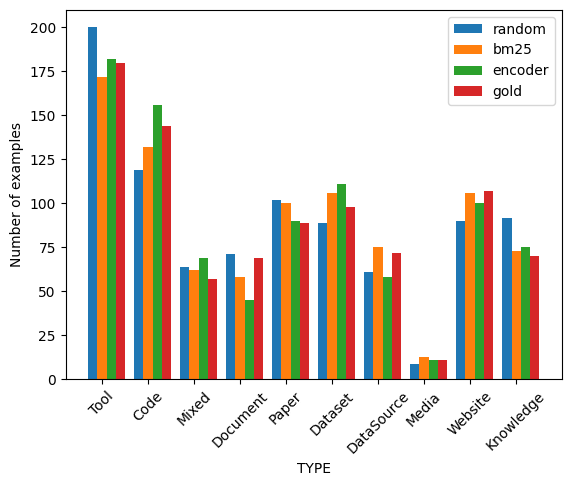

In [24]:
from collections import Counter
import matplotlib.pyplot as plt

dict0 = Counter(gold_types)
dict1 = Counter(types_methods[0])
dict2 = Counter(types_methods[1])
dict3 = Counter(types_methods[2])
# すべてのラベルを統一
all_labels = set(dict1.keys()).union(dict2.keys()).union(dict3.keys()).union(dict0.keys())

# 各辞書の値をリストに変換（ラベルがない場合は0を設定）
values0 = [dict0.get(label, 0) for label in all_labels]
values1 = [dict1.get(label, 0) for label in all_labels]
values2 = [dict2.get(label, 0) for label in all_labels]
values3 = [dict3.get(label, 0) for label in all_labels]

# 各棒グラフの位置をずらすためのオフセット
bar_width = 0.20
x = np.arange(len(all_labels))

# プロット
plt.bar(x, values1, width=bar_width, label='random')
plt.bar(x + bar_width, values2, width=bar_width, label='bm25')
plt.bar(x + 2*bar_width, values3, width=bar_width, label='encoder')
plt.bar(x + 3*bar_width, values0, width=bar_width, label='gold')

# ラベルと軸の設定
plt.xlabel('TYPE')
plt.ylabel('Number of examples')
# plt.title('Bar Graph for Multiple Dictionaries')
plt.xticks(x + bar_width, all_labels, rotation=45)  # X軸ラベルを設定
plt.legend()

# グラフを表示
plt.show()

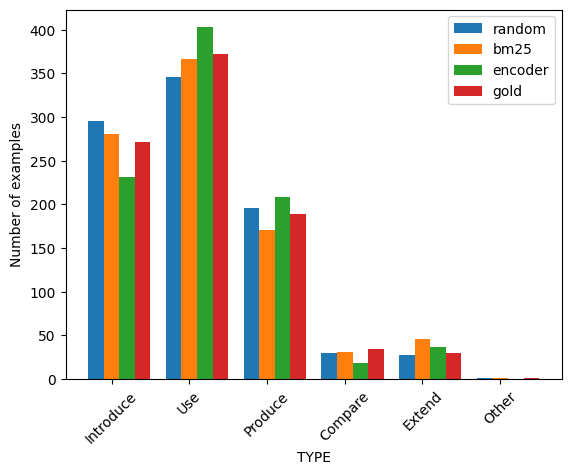

In [25]:
from collections import Counter
import matplotlib.pyplot as plt

dict0 = Counter(gold_funcs)
dict1 = Counter(funcs_methods[0])
dict2 = Counter(funcs_methods[1])
dict3 = Counter(funcs_methods[2])
# すべてのラベルを統一
all_labels = set(dict1.keys()).union(dict2.keys()).union(dict3.keys()).union(dict0.keys())

# 各辞書の値をリストに変換（ラベルがない場合は0を設定）
values0 = [dict0.get(label, 0) for label in all_labels]
values1 = [dict1.get(label, 0) for label in all_labels]
values2 = [dict2.get(label, 0) for label in all_labels]
values3 = [dict3.get(label, 0) for label in all_labels]

# 各棒グラフの位置をずらすためのオフセット
bar_width = 0.20
x = np.arange(len(all_labels))

# プロット
plt.bar(x, values1, width=bar_width, label='random')
plt.bar(x + bar_width, values2, width=bar_width, label='bm25')
plt.bar(x + 2*bar_width, values3, width=bar_width, label='encoder')
plt.bar(x + 3*bar_width, values0, width=bar_width, label='gold')

# ラベルと軸の設定
plt.xlabel('TYPE')
plt.ylabel('Number of examples')
# plt.title('Bar Graph for Multiple Dictionaries')
plt.xticks(x + bar_width, all_labels, rotation=45)  # X軸ラベルを設定
plt.legend()

# グラフを表示
plt.show()

In [16]:
# 299 * 3 (seeds)

In [17]:
model_name = model_names[0]
icl_method = "random"
k = 1
golds = []
preds = []
for seed in [111, 5374, 93279]:
    # print(seed)
    # create gold answer
    train_df, eval_df = train_test_split(csv_dataset, test_size = 0.1, random_state=int(seed))
    gold_types, gold_funcs = [], []
    for i, row in eval_df.iterrows():
        gold_types.append(row['type'])
        gold_funcs.append(row['function'].split("（")[0])
    golds += gold_types

    # create pred answer
    pred_data_path = f"/data/group1/z40436a/ME/URL_Citation_Classification_Intermediate/result/output/{model_name}/{icl_method}/{str(seed)}_{str(k)}shot.json"
    with open(pred_data_path, 'r') as json_file:
        LLM_responses = json.load(json_file)

    pred_types, pred_funcs = pred_type_and_func(LLM_responses)

    pred_types = [pred if pred in list(set(gold_types)) else "FormatError" for pred in pred_types]
    preds += pred_types
    pred_funcs = [pred if pred in list(set(gold_funcs)) else "FormatError" for pred in pred_funcs]

    metrics_types_seeds.append(evaluation_metrics(gold_types, pred_types, "type"))
    metrics_funcs_seeds.append(evaluation_metrics(gold_funcs, pred_funcs, "func"))


print("TYPE:", end="")
round_print(ave_metrics_seed(metrics_types_seeds))
show_types.append(ave_metrics_seed(metrics_types_seeds))
print("FUNC:", end="")
round_print(ave_metrics_seed(metrics_funcs_seeds))
show_funcs.append(ave_metrics_seed(metrics_funcs_seeds))

TYPE:

NameError: name 'ave_metrics_seed' is not defined

In [74]:
print(len(golds))

897


In [75]:
if len(golds) == len(preds) == (len(eval_df)*3):
    print("OK")

OK


In [76]:
import collections
collections.Counter(zip(golds, preds))

Counter({('Tool', 'Tool'): 110,
         ('Code', 'Code'): 108,
         ('Dataset', 'Dataset'): 56,
         ('Paper', 'Paper'): 56,
         ('Website', 'Website'): 47,
         ('Tool', 'Code'): 44,
         ('Document', 'Document'): 32,
         ('DataSource', 'DataSource'): 27,
         ('Mixed', 'Mixed'): 25,
         ('Dataset', 'DataSource'): 23,
         ('DataSource', 'Dataset'): 22,
         ('Code', 'Tool'): 21,
         ('Mixed', 'Code'): 19,
         ('Website', 'DataSource'): 19,
         ('Paper', 'Document'): 18,
         ('Knowledge', 'Code'): 16,
         ('Website', 'Tool'): 14,
         ('Tool', 'Website'): 13,
         ('Knowledge', 'DataSource'): 13,
         ('Knowledge', 'Knowledge'): 12,
         ('Knowledge', 'Tool'): 11,
         ('Knowledge', 'Dataset'): 11,
         ('Website', 'Dataset'): 10,
         ('DataSource', 'Website'): 10,
         ('Document', 'Code'): 9,
         ('Dataset', 'Website'): 9,
         ('Document', 'DataSource'): 8,
         ('Code